In [1]:
import matplotlib as mpl
from utils import plot, softmax
import matplotlib.pyplot as plt
import numpy as np
import _pickle as pkl
import scipy.stats as stats
import tensorflow as tf
import time
import scipy
from ig_attack import IntegratedGradientsAttack
from utils import dataReader, get_session, integrated_gradients
from model import Model

tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
X, y = dataReader()

In [3]:
classes = ['Daffodil','Snowdrop', 'Lily Valley', 'Bluebell',
           'Crocus', 'Iris', 'Tigerlily', 'Tulip',
           'Fritillary', 'Sunflower', 'Daisy', 'Colts Foot',
            'Dandelalion', 'Cowslip', 'Buttercup', 'Windflower',
            'Pansy']

Image ID: 28, Image Label : Windflower


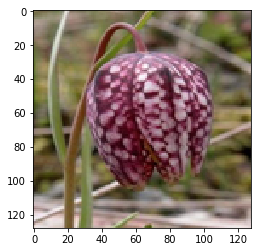

In [4]:
n = 28
original_label = y[n]
test_image = X[n]
plt.rcParams["figure.figsize"]=8,8
print("Image ID: {}, Image Label : {}".format(n, classes[y[n]]))
%matplotlib inline
plt.imshow(X[n])

In [5]:
tf.reset_default_graph()
sess = get_session()
model = Model(create_saliency_op = 'ig')
# restore models
model_dir = 'models/nat_trained'

saver = tf.train.Saver()
checkpoint = tf.train.latest_checkpoint(model_dir)
saver.restore(sess, checkpoint)

In [6]:
k_top = 1000 #Recommended for ImageNet
eval_k_top = 1000
num_steps = 100 #Number of steps in Integrated Gradients Algorithm (refer to the original paper)
attack_method = 'topK'
epsilon = 8.0 #Maximum allowed perturbation for each pixel
attack_steps = 100
attack_times = 1
alpha = 1.0
attack_measure = "kendall"
reference_image = np.zeros((128, 128, 3)) #Our chosen reference(the mean image)

module = IntegratedGradientsAttack(sess = sess, test_image = test_image, 
                                   original_label = original_label, NET = model,
                                   attack_method = attack_method, epsilon = epsilon,
                                   k_top = k_top, eval_k_top = eval_k_top, num_steps = num_steps,
                                   attack_iters = attack_steps,
                                   attack_times = attack_times,
                                   alpha = alpha,  
                                   attack_measure = attack_measure,
                                   reference_image = reference_image, 
                                   same_label = True)

In [7]:
output = module.iterative_attack_once()

print('''For maximum allowed perturbation size equal to {}, the resulting perturbation size was equal to {}'''.format(epsilon, np.max(np.abs(test_image - module.perturbed_image))))

print('''{} % of the {} most salient pixels in the original image are among {} most salient pixels of the 
perturbed image'''.format(output[0]*100, eval_k_top, eval_k_top))

print("The spearman rank correlation between salieny maps is equal to {}".format(output[1]))

print("The kendall rank correlation between salieny maps is equal to {}".format(output[2]))

nat_prediction = sess.run(model.prediction, feed_dict={model.input: [test_image], model.label: [original_label]})
adv_prediction = sess.run(model.prediction, feed_dict={model.input: [module.perturbed_image], model.label: [original_label]})
print('nat_prediction: %s, adv_prediction: %s'%(int(nat_prediction), int(adv_prediction)))

For maximum allowed perturbation size equal to 8.0, the resulting perturbation size was equal to 8
0.1 % of the 1000 most salient pixels in the original image are among 1000 most salient pixels of the 
perturbed image
The spearman rank correlation between salieny maps is equal to 0.3861115868359041
The kendall rank correlation between salieny maps is equal to 0.26067198513393214
nat_prediction: 15, adv_prediction: 15


In [8]:
nat_output = sess.run(model.output_with_relu, feed_dict={model.input: [test_image]})
nat_pred = softmax(nat_output)
adv_output = sess.run(model.output_with_relu, feed_dict={model.input: [module.perturbed_image]})
adv_pred = softmax(adv_output)
print('original prediction: {}, confidence: {}'.format(classes[np.argmax(nat_pred)], np.max(nat_pred)))
print('perturbed prediction: {}, confidence: {}'.format(classes[np.argmax(adv_pred)], np.max(adv_pred)))

original prediction: Windflower, confidence: 0.9999985694885254
perturbed prediction: Windflower, confidence: 0.9996143579483032


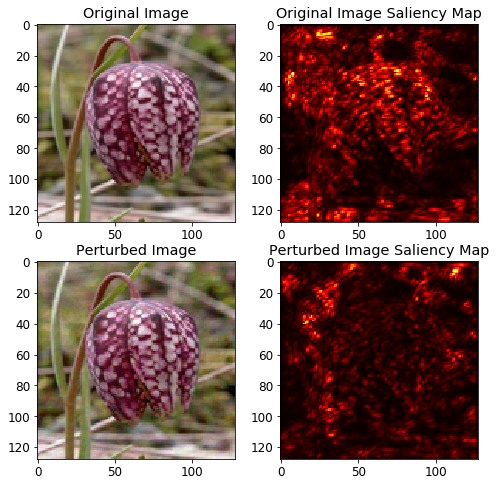

In [9]:
original_IG = integrated_gradients(sess, reference_image, test_image, original_label, model, gradient_func='output_input_gradient', steps=num_steps)

mpl.rcParams["figure.figsize"]=8,8
plt.rc("text",usetex=False)
plt.rc("font",family="sans-serif",size=12)
saliency = np.sum(np.abs(original_IG),-1)
original_saliency = 128*128*saliency/np.sum(saliency)
plt.subplot(2,2,1)
plt.title("Original Image")
image = X[n].astype(np.uint8)
plt.imshow(image)
plt.subplot(2,2,2)
plt.title("Original Image Saliency Map")
plt.imshow(original_saliency, cmap="hot")

perturbed_IG = integrated_gradients(sess, reference_image, module.perturbed_image, original_label, model, gradient_func='output_input_gradient', steps=num_steps)
saliency = np.sum(np.abs(perturbed_IG),-1)
perturbed_saliency = 128*128*saliency/np.sum(saliency)
plt.subplot(2,2,3)
plt.title("Perturbed Image")
perturbed_image = (module.perturbed_image).astype(np.uint8)
plt.imshow(perturbed_image)
plt.subplot(2,2,4)
plt.title("Perturbed Image Saliency Map")
plt.imshow(perturbed_saliency, cmap="hot")